<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/Regression/VineyardExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from itertools import combinations

In [121]:
columns = ['x0', 'x1', 'x2', 'x3', 'u']
feature_ranges = {"x0": [1, 17], "x1": [-9, -4], "x2": [0, 3], "x3": [0, 50]}
source_path = "./Data/podaci.csv"
train_size, test_size, val_size = 0.8, 0.2, 0.2

In [122]:
df = pd.read_csv(source_path, names=columns)
df.head()

,x0,x1,x2,x3,u
0,9.353670,-5.681740,1.739091,26.117712,95.610349
1,7.136365,-8.842209,1.712237,42.389300,171.811854
2,11.457191,-8.771499,1.500788,41.984114,173.865403
3,8.772591,-4.087157,2.443511,12.612862,53.146681
4,4.958833,-8.140877,1.651389,34.904362,142.692822


In [123]:
df.describe()

,x0,x1,x2,x3,u
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,8.791439,-6.613959,1.528241,26.049980,108.149899
std,4.653434,1.412722,0.858456,13.886081,34.839117
min,1.253278,-8.994504,0.053720,0.049785,22.550903
25%,4.679236,-7.922337,0.758000,15.002370,81.192576
50%,8.724418,-6.601377,1.552406,26.236388,110.872981
75%,12.766403,-5.485084,2.291555,36.993059,136.567023
max,16.991696,-4.006333,2.989752,49.719666,185.125604


Sensor data are not out of range for all features.

In [124]:
df.dtypes

x0    float64
x1    float64
x2    float64
x3    float64
u     float64
dtype: object

In [125]:
df_missing = df.isnull().sum()
df_missing

x0    0
x1    0
x2    0
x3    0
u     0
dtype: int64

In [126]:
def miss_percentage(df):
    """
    Calculate missing value percentage per dataset features (columns in dataframe).
    :param df: input pandas dataframe with missing values
    :return:   pandas dataframe, index = column names, columns = [missing values percentage, missing count]
    """
    df_missing = df.isnull().sum().reset_index()
    df_missing.columns = ['features', 'missing_counts']
    df_len = df.shape[0]
    df_missing['missing_percentage'] = df_missing['missing_counts'].apply(lambda v: v/df_len)

    return df_missing.sort_values(by='missing_percentage', ascending=False).set_index(keys='features')

In [127]:
df_miss_info = miss_percentage(df)
df_miss_info

,missing_counts,missing_percentage
features,,
x0,0,0.0
x1,0,0.0
x2,0,0.0
x3,0,0.0
u,0,0.0


All features are numeric (float) and there is no missing values.

### Calculate feature correlations

In [128]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [129]:
def plot_feature_distributions(df):
  """
  Plot histograms of all featues.
  """

  fig, ax = plt.subplots(2, 2)
  sns.distplot(df['x0'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[0, 0])
  sns.distplot(df['x1'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[0, 1])
  sns.distplot(df['x2'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[1, 0])
  sns.distplot(df['x3'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[1, 1])

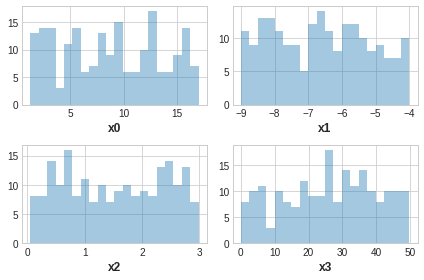

In [130]:
plot_feature_distributions(df)

All features need to be normalized with sifting distribution to become more like bell shape curve.

In [131]:
def plot_target_distribution():
  """
  Plot histograms of target variable.
  """

  sns.distplot(df['u'], hist=True, kde=False, label='All values', bins=40)

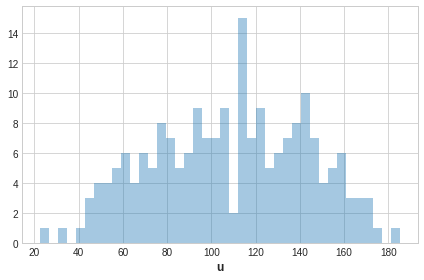

In [132]:
plot_target_distribution()

Target variable can be just standardized because distribution is approximately bell shape curve.

### Correlations between features and target variable

In [133]:
import scipy as sc

def get_correlation_coefficients(features_combinations: list):
  """
  Calculate Pearson and Spearman correlation coefficients between features
  and target variable.
  :param features_combinations: list of combinations of input features and target names, list of tuples
  :return result_coefficients: dict, key - name of related features, value - pandas dataframe
  """

  result_coefficients = {}

  for features in features_combinations:
    
      stats_pe_spe = {"corr": [], "p-value": []}

      pearson_price_points = sc.stats.pearsonr(df[features[0]], df[features[1]])
      spearman_price_points = sc.stats.spearmanr(df[features[0]], df[features[1]])

      for i in range(len(list(stats_pe_spe.keys()))):
        stats_pe_spe[list(stats_pe_spe.keys())[i]].append(pearson_price_points[i])
        stats_pe_spe[list(stats_pe_spe.keys())[i]].append(spearman_price_points[i])

      result_coefficients[features[0] + "-" + features[1]] = pd.DataFrame(stats_pe_spe, columns=['corr', 'p-value'], index=['pearson', 'spearman'])  
  
  return result_coefficients

In [134]:
#target = [columns.pop(-1)]
#features = columns
r = 2
features_target = list(set(list(combinations(columns, r))))
result_coefficients = get_correlation_coefficients(features_target)


In [135]:
for feature in list(result_coefficients.keys()):
  print(feature)
  print("----------------------------")
  print(result_coefficients[feature])
  print("\n")

x1-x2
----------------------------
              corr   p-value
pearson   0.006414  0.928178
spearman  0.005717  0.935967


x0-x1
----------------------------
              corr   p-value
pearson  -0.071891  0.311718
spearman -0.076520  0.281502


x1-u
----------------------------
              corr       p-value
pearson  -0.573213  7.299622e-19
spearman -0.563587  3.677339e-18


x2-u
----------------------------
              corr   p-value
pearson  -0.002399  0.973100
spearman  0.003611  0.959531


x1-x3
----------------------------
              corr   p-value
pearson  -0.040232  0.571643
spearman -0.043659  0.539315


x2-x3
----------------------------
              corr   p-value
pearson  -0.034601  0.626679
spearman -0.024545  0.730097


x0-x3
----------------------------
              corr   p-value
pearson   0.080445  0.257477
spearman  0.095497  0.178580


x3-u
----------------------------
              corr       p-value
pearson   0.828818  7.960407e-52
spearman  0.833077  8.

In [136]:
def plot_feature_correlations(df):
  """
  Draw scatter plots and histograms of all features.
  :param df: input pandas dataframe
  """
  sns.pairplot(df)


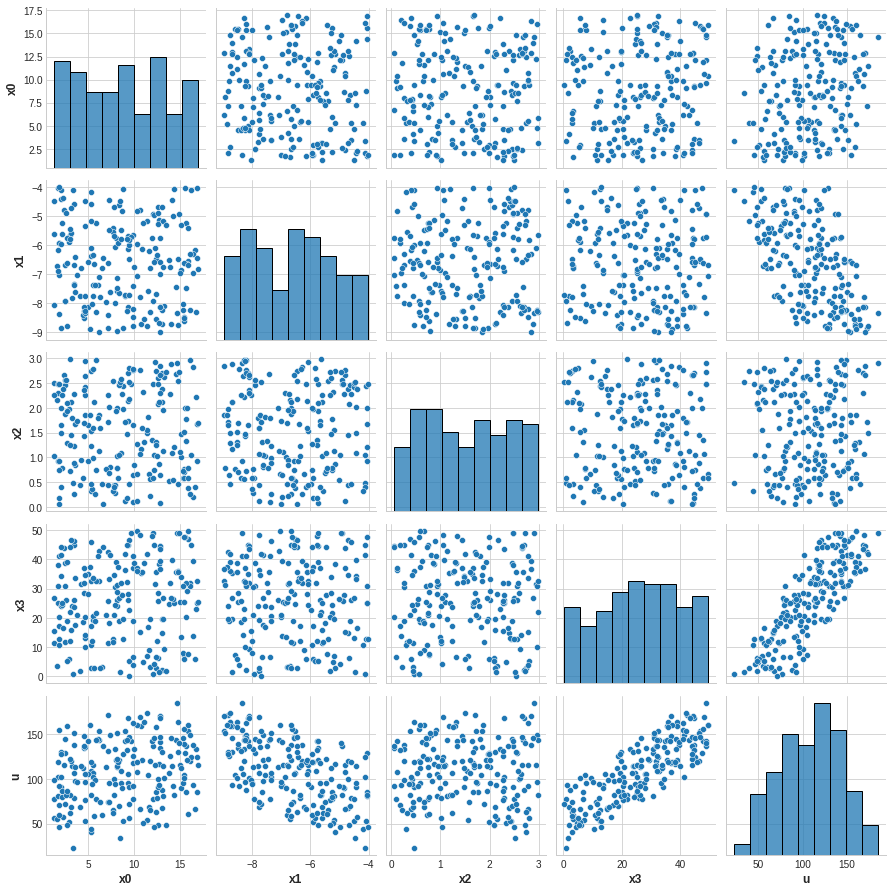

In [137]:
plot_feature_correlations(df)

x1 and x3 are features of high relevance.
All input features are independent between each other.

### Prepare dataset

In [138]:
def split_data(df: pd.DataFrame, features: list, target: list, train_size: float, 
               test_size: float, val_size: float):
  """
  Split dataset on train, test and validation subsets.
  :param df:          input pandas DataFrame
  :param features:    list of input features names
  :param target:      list of target column names
  :param train_size:  fraction of train size
  :param test_size:   fraction of test size
  :param val_size:    fraction of validation size
  :return:            dictionary, keys=names of DataFrame, columns=DataFrame
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  x_train, x_test, y_train, y_test = train_test_split(df[features], df[target],
                                     test_size=test_size, train_size=train_size)
    
  # split train set on train and validation subsets
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                      test_size=val_size, train_size=train_size)
  
  dataset_dict = {
      'x_train': x_train,
      'y_train': y_train,
      'x_val': x_val,
      'y_val': y_val,
      'x_test': x_test,
      'y_test': y_test
  }

  return dataset_dict

In [139]:
target = [columns.pop(-1)]
features = columns
dataset = split_data(df, features, target, train_size, test_size, val_size)

In [140]:
print("Train dataset shape: {}".format(dataset['x_train'].shape))
print("Validation dataset shape: {}".format(dataset['x_val'].shape))
print("Test dataset shape: {}".format(dataset['x_test'].shape))

Train dataset shape: (128, 4)
Validation dataset shape: (32, 4)
Test dataset shape: (40, 4)


In [141]:
def cause_relevant_features(df: pd.DataFrame, features: list, f_ranges: list):
  """
  Cause new data based on calculated statistics.
  :param df:          input pandas DataFrame
  :param f_ranges:    list of input features names
  :return new_df:     pandas DataFrame with new data
  """

  new_data = {}

  for idx in range(len(features)):

    std = df[features[idx]].std()
    mean = df[features[idx]].mean()

    data_range = [mean - (1.5 * std), mean + (1.5 * std)]

    new_data[features[idx]] = np.random.uniform(data_range[0], data_range[1], f_ranges[1]).reshape(f_ranges[1], 1).tolist()

  new_df = pd.DataFrame.from_dict(new_data)
  
  for fidx in range(len(features)):
    new_df[features[fidx]] = new_df[features[fidx]].map(lambda x: x[0])

  return new_df


In [142]:
f_ranges = [1, 100]
new_data = cause_relevant_features(dataset['x_train'], features, f_ranges)
new_data.describe()

,x0,x1,x2,x3
count,100.000000,100.000000,100.000000,100.000000
mean,8.066266,-6.811970,1.489523,24.170981
std,4.221712,1.089833,0.733311,13.026913
min,1.813938,-8.798903,0.283313,5.190343
25%,4.268929,-7.679176,0.806388,12.819432
50%,7.891858,-6.841703,1.613437,21.944516
75%,11.858305,-5.890141,2.051775,36.300823
max,15.789222,-4.794506,2.753568,46.323048


In [143]:
def get_target_values(df, target):
  """
  Return values of target variable based on input feature values.
  :param df:               pandas dataframe with input features
  :return target_result:   pandas dataframe with input features and target values
  """
  
  def calc_target_func(x0, x1, x2, x3):
    """
    Return target value.
    """

    return x0 + (x1**2) + x2 + (2*x3)
  

  df[target[0]] = df.apply(lambda row: calc_target_func(row['x0'], row['x1'], row['x2'], row['x3']), axis=1)

  return df

In [144]:
new_data = get_target_values(new_data, target)
new_data.describe()

,x0,x1,x2,x3,u
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,8.066266,-6.811970,1.489523,24.170981,105.476544
std,4.221712,1.089833,0.733311,13.026913,32.533227
min,1.813938,-8.798903,0.283313,5.190343,44.247227
25%,4.268929,-7.679176,0.806388,12.819432,76.905030
50%,7.891858,-6.841703,1.613437,21.944516,104.893825
75%,11.858305,-5.890141,2.051775,36.300823,128.664408
max,15.789222,-4.794506,2.753568,46.323048,170.650622


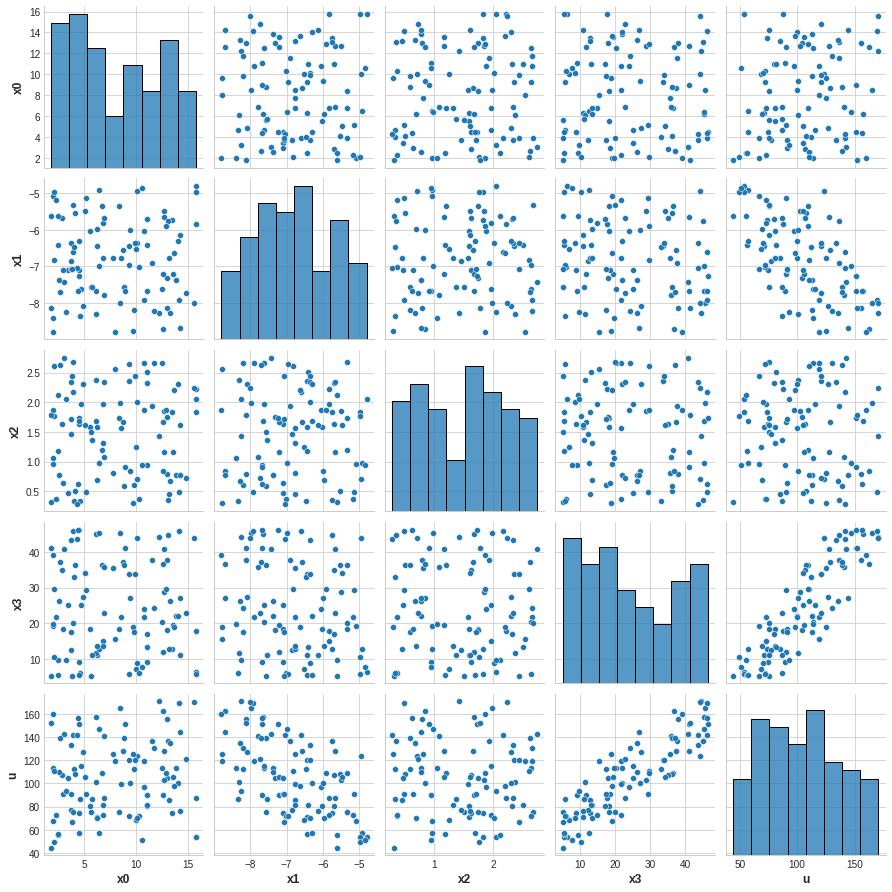

In [145]:
plot_feature_correlations(new_data)

In a new dataset features containes independent between each other while x1 and x3 features preserve relevance in relation to target variable.

In [150]:
def create_extra_train_dataset(df, df_new):
  """
  Extend train dataset with new data.
  :param df:               pandas dataframe with input features
  :param df_new:           pandas dataframe with input augmented features
  :return df_result:       pandas dataframe with input features and target values
  """

  return pd.concat([df, df_new], axis=0).reset_index()[features + target]

In [151]:
x_train = dataset['x_train'].reset_index()[features]
y_train = dataset['y_train'].reset_index()[target]


new_data = new_data.reset_index()[features + target]

train_data = pd.concat([x_train, y_train], axis=1)

train_new_data = create_extra_train_dataset(train_data, new_data)
train_data

,x0,x1,x2,x3,u
0,14.784221,-6.472594,2.537213,35.518199,130.252305
1,3.272568,-7.803455,1.789375,24.172143,114.300132
2,8.772591,-4.087157,2.443511,12.612862,53.146681
3,3.489468,-7.345542,0.894991,46.429174,151.199796
4,12.777419,-6.581508,2.656067,44.178791,147.107316
...,...,...,...,...,...
123,12.127301,-6.573084,0.749782,45.049345,146.181211
124,8.772211,-8.836428,1.968881,19.491149,127.805848
125,12.826080,-8.125193,2.295455,43.440872,168.022035
126,2.639333,-4.899179,2.563285,26.109461,81.423493


In [152]:
train_new_data

,x0,x1,x2,x3,u
0,14.784221,-6.472594,2.537213,35.518199,130.252305
1,3.272568,-7.803455,1.789375,24.172143,114.300132
2,8.772591,-4.087157,2.443511,12.612862,53.146681
3,3.489468,-7.345542,0.894991,46.429174,151.199796
4,12.777419,-6.581508,2.656067,44.178791,147.107316
...,...,...,...,...,...
223,9.304863,-6.975986,2.653507,5.751647,72.126040
224,13.674335,-6.635485,2.213120,19.087028,98.091169
225,3.896988,-7.075824,2.442526,5.190343,66.787480
226,13.246152,-8.283380,0.679276,26.293411,135.126636


### Normalize input datasets

In [153]:
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

def normalize_features(x, y):
  """
  Use Yeo-Johnson transform to normalize input features and target variable.
  :param x:           pandas dataframe with input features
  :param y:           pandas dataframe with target variable
  :return df_trans:   pandas dataframe with transformed data
  """

  transformer_f = PowerTransformer(method='yeo-johnson', standardize=True)
  x_trans = transformer_f.fit_transform(x)
  x_trans = pd.DataFrame(x_trans, columns=x.columns)

  transformer_t = PowerTransformer(method='yeo-johnson', standardize=True)
  y_trans = transformer_t.fit_transform(y)
  y_trans = pd.DataFrame(y_trans, columns=y.columns)

  df_trans = pd.concat([x_trans, y_trans], axis=1)

  return df_trans

def pca(x):
  """
  Get new features by PCA analysis.
  :param x:                 pandas dataframe with input features
  :return train_pca, pca:   pandas dataframe with transformed data, PCA object
  """

  # Create principal components
  pca = PCA()
  x_pca = pca.fit_transform(x)

  # Convert to dataframe
  component_names = [f"PC{i+1}" for i in range(x_pca.shape[1])]
  train_pca = pd.DataFrame(x_pca, columns=component_names)

  return train_pca, pca

In [154]:
# normalize datasets
norm_train = normalize_features(train_data[['x0', 'x1', 'x2', 'x3']], train_data[['u']])

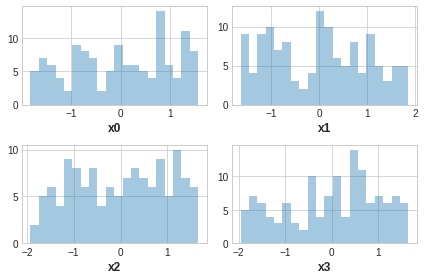

In [155]:
plot_feature_distributions(norm_train)

In [156]:
# normalize new datasets
norm_train_new = normalize_features(train_new_data[['x0', 'x1', 'x2', 'x3']], train_new_data[['u']])

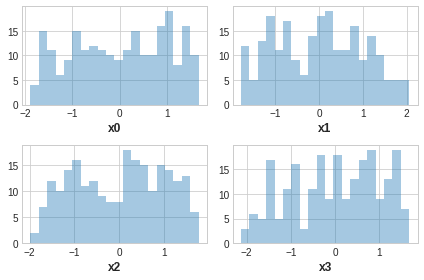

In [157]:
plot_feature_distributions(norm_train_new)

### PCA analysis
With pca analysis we will get independent principal components with explained variance ratio.

In [161]:
# pca analysis train dataset
train_pca, pca_train = pca(norm_train[['x0', 'x1', 'x2', 'x3']])


In [162]:
# Look at explained variance
print(pca_train.explained_variance_ratio_)

[0.29692973 0.26302067 0.22773802 0.21231158]


In [163]:
# pca analysis train dataset
train_new_pca, pca_train_new = pca(norm_train_new[['x0', 'x1', 'x2', 'x3']])

In [164]:
# Look at explained variance
print(pca_train_new.explained_variance_ratio_)

[0.29233718 0.25934059 0.23315315 0.21516908]


Like me can see all the components contains near the same variance ratio in dataset. So all 4 components will be used for both datasets.

In [167]:
train_pca.columns = features
train_pca = pd.concat([train_pca, norm_train['u']], axis=1)
train_pca

,x0,x1,x2,x3,u
0,-0.182561,-0.199750,0.262743,1.812315,0.581144
1,0.693802,-1.030292,-0.408557,-0.681456,0.124003
2,1.664904,1.301256,0.461396,0.888231,-1.596107
3,-0.491475,-1.278258,1.018137,-1.085465,1.185383
4,-0.162684,-0.775269,0.662362,1.752696,1.067008
...,...,...,...,...,...
123,-1.465875,-0.044406,1.027879,0.117734,1.040241
124,-0.091556,-0.872735,-1.445015,0.172468,0.510857
125,-0.798348,-1.304590,-0.108607,1.331493,1.673504
126,2.012916,-0.226171,1.023724,0.087074,-0.808236


In [168]:
train_new_pca.columns = features
train_new_pca = pd.concat([train_new_pca, norm_train_new['u']], axis=1)
train_new_pca

,x0,x1,x2,x3,u
0,-0.194126,0.012815,-1.349724,1.462470,0.668435
1,0.136143,-1.311975,0.177591,-0.680209,0.211006
2,2.150857,0.670944,-0.291923,1.071281,-1.645001
3,-1.079710,-1.076727,1.369433,0.172922,1.257356
4,-0.397075,-0.532976,-1.118907,1.735574,1.143255
...,...,...,...,...,...
223,1.353672,-0.038258,-1.475304,-0.533611,-1.046946
224,0.327400,0.459161,-1.305646,0.432684,-0.263115
225,1.678818,-0.769651,-0.564842,-1.047049,-1.212662
226,-1.600903,0.674035,-0.379781,-0.706553,0.806593


### Normalize validation and test datasets
Nemoze se tu normalizirati dataset jer nam treba i normalize object za train skriptu zato sto kada dobijemo rezultat trebamo ga unnormalizirati da ga usporedimo sa testnim datasetom. Dakle inace se train i val set normaliziraju a testni ne. Uglavnom tu se netreba nista saveati od datasetova jer ce se svejedno iste funkcije zvati kasnije za splitanje podataka normalizaciju pca i ostalo :D!!!

### Save datasets

In [173]:
def save_dataset(dataset, path):
  """
  Save dataset as .csv file to desired location.
  :param dataset:  pandas dataframe
  :param path:     store location, str
  """

  dataset.to_csv(path, index=False)

In [174]:
train_path = './Data/train.csv'
train_new_path = './Data/train_new.csv'
train_pca_path = './Data/train_pca.csv'
train_new_pca_path = './Data/train_new_pca.csv'
test_path = './Data/test.csv'
val_path = './Data/val.csv'

save_dataset(norm_train, train_path)
save_dataset(norm_train_new, train_new_path)
save_dataset(train_pca, train_pca_path)
save_dataset(train_new_pca, train_new_pca_path)
save_dataset(test, test_path)